In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [3]:
from hiv_patient import HIVPatient
from buffer import Buffer

### Create dataset

In [4]:
patient = HIVPatient(clipping=False,logscale=False)

In [5]:
FQI_buffer = Buffer(50000)


In [6]:
for j in tqdm(range(30)):
    s = patient.reset(mode="unhealthy")
    for i in range(200):
        a = np.random.choice(4)
        s_, r, d, _ = patient.step(a)
        FQI_buffer.append(s,a,r,s_,d)
        s = s_



  0%|          | 0/30 [00:00<?, ?it/s]

Patient extra '  ' unrecognized. State unchanged.


  3%|▎         | 1/30 [00:21<10:34, 21.89s/it]

Patient extra '  ' unrecognized. State unchanged.


  7%|▋         | 2/30 [00:45<10:39, 22.84s/it]

Patient extra '  ' unrecognized. State unchanged.


 10%|█         | 3/30 [01:15<11:45, 26.13s/it]

Patient extra '  ' unrecognized. State unchanged.


 13%|█▎        | 4/30 [01:37<10:32, 24.34s/it]

Patient extra '  ' unrecognized. State unchanged.


 17%|█▋        | 5/30 [01:56<09:28, 22.73s/it]

Patient extra '  ' unrecognized. State unchanged.


 20%|██        | 6/30 [02:19<09:01, 22.58s/it]

Patient extra '  ' unrecognized. State unchanged.


 23%|██▎       | 7/30 [02:49<09:35, 25.01s/it]

Patient extra '  ' unrecognized. State unchanged.


 27%|██▋       | 8/30 [03:23<10:16, 28.04s/it]

Patient extra '  ' unrecognized. State unchanged.


 30%|███       | 9/30 [03:38<08:24, 24.02s/it]

Patient extra '  ' unrecognized. State unchanged.


 33%|███▎      | 10/30 [03:53<07:04, 21.24s/it]

Patient extra '  ' unrecognized. State unchanged.


 37%|███▋      | 11/30 [04:08<06:06, 19.29s/it]

Patient extra '  ' unrecognized. State unchanged.


 40%|████      | 12/30 [04:27<05:44, 19.12s/it]

Patient extra '  ' unrecognized. State unchanged.


 43%|████▎     | 13/30 [04:42<05:05, 17.97s/it]

Patient extra '  ' unrecognized. State unchanged.


 47%|████▋     | 14/30 [04:57<04:33, 17.08s/it]

Patient extra '  ' unrecognized. State unchanged.


 50%|█████     | 15/30 [05:15<04:20, 17.38s/it]

Patient extra '  ' unrecognized. State unchanged.


 53%|█████▎    | 16/30 [05:30<03:51, 16.54s/it]

Patient extra '  ' unrecognized. State unchanged.


 57%|█████▋    | 17/30 [05:45<03:27, 15.94s/it]

Patient extra '  ' unrecognized. State unchanged.


 60%|██████    | 18/30 [06:05<03:27, 17.26s/it]

Patient extra '  ' unrecognized. State unchanged.


 63%|██████▎   | 19/30 [06:20<03:01, 16.49s/it]

Patient extra '  ' unrecognized. State unchanged.


 67%|██████▋   | 20/30 [06:35<02:40, 16.03s/it]

Patient extra '  ' unrecognized. State unchanged.


 70%|███████   | 21/30 [06:49<02:20, 15.56s/it]

Patient extra '  ' unrecognized. State unchanged.


 73%|███████▎  | 22/30 [07:09<02:14, 16.78s/it]

Patient extra '  ' unrecognized. State unchanged.


 77%|███████▋  | 23/30 [07:27<02:00, 17.19s/it]

Patient extra '  ' unrecognized. State unchanged.


 80%|████████  | 24/30 [07:41<01:38, 16.37s/it]

Patient extra '  ' unrecognized. State unchanged.


 83%|████████▎ | 25/30 [08:00<01:25, 17.11s/it]

Patient extra '  ' unrecognized. State unchanged.


 87%|████████▋ | 26/30 [08:16<01:06, 16.72s/it]

Patient extra '  ' unrecognized. State unchanged.


 90%|█████████ | 27/30 [08:34<00:51, 17.05s/it]

Patient extra '  ' unrecognized. State unchanged.


 93%|█████████▎| 28/30 [08:48<00:32, 16.20s/it]

Patient extra '  ' unrecognized. State unchanged.


 97%|█████████▋| 29/30 [09:03<00:15, 15.76s/it]

Patient extra '  ' unrecognized. State unchanged.


100%|██████████| 30/30 [09:21<00:00, 18.72s/it]


### FQI 

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
from typing import Optional,List, Callable
from sklearn.base import BaseEstimator

def estimator_factory(*args, **kwargs):
    return RandomForestRegressor(*args, **kwargs)


def update(memory : Buffer,
    gamma : float = 0.98,
    estimator : Optional[BaseEstimator] = None,
    estimator_factory: Callable = estimator_factory):

    states, actions, rewards, next_state, done  = memory.get()
    actions = np.expand_dims(actions,axis=1)
    target = np.expand_dims(rewards,axis=1)
    #target = rewards

    if estimator is not None:
        q_values = np.zeros((len(rewards),4))
        for a in range(4):
            actions_ = a*np.ones((len(rewards),1))
            X = np.concatenate((next_state,actions_),axis=1)
            q_values[:,a] = estimator.predict(X)
            
        #print(f"q_values --> {q_values}")
        qmax = np.expand_dims(np.max(q_values,axis=1),axis=1)
        #print(f"Shape de qmax --> {qmax.shape}, Shape de target --> {target.shape}, Shape de done --> {done.shape}")
        target += gamma*qmax * (1 - np.expand_dims(done,axis=1))
        #print(f"Shape de target --> {target.shape}")

    if estimator is None:
        estimator = estimator_factory()


    #print(f"States shape --> {states.shape}, actions shape --> {actions.shape},target{target.shape}")
    data = np.concatenate((states,actions),axis=1)
    #print(f"Data shape --> {data.shape}")
    estimator.fit(data,target)


    return estimator






### Entraînement !

In [9]:
estimator = None

for j in tqdm(range(10)):

    s = patient.reset(mode="unhealthy")

    for step in range(200):
        
        if np.random.random()<0.15:
            action = np.random.choice(4)
        
        else:
            if estimator is not None:
                greedy = np.zeros((4,2))
                for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
                    sta = np.expand_dims(s,axis=1)
                    act = np.expand_dims(np.array([a]),axis=1)
                    X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
                    q = estimator.predict(X)
                    #print(f'Q -->{q}')
                    greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
                action = greedy[np.argmax(greedy[:,0]),0]
            
            else:
                action = np.random.choice(4)


        s_, r, d, _ = patient.step(int(action))
        FQI_buffer.append(s,a,r,s_,d)
        s = s_

        if (j*step % 500 == 0):
            com = 0
            while com < 10:
                estimator = update(FQI_buffer,estimator=estimator)



  0%|          | 0/10 [00:00<?, ?it/s]

Patient extra '  ' unrecognized. State unchanged.


/tmp/ipykernel_879/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
/tmp/ipykernel_879/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
/tmp/ipykernel_879/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
/tmp/ipykernel_879/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
/tmp/ipykernel_879/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

KeyboardInterrupt: 

### Affichons les résultats

In [10]:

s = patient.reset(mode="unhealthy")
T1,T2,T1_,T2_,V,E = np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200)
actions = []
for step in tqdm(range(200)):
    T1[step], T2[step], T1_[step], T2_[step], V[step], E[step] = s 

    greedy = np.zeros((4,2))
        
    for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
        sta = np.expand_dims(s,axis=1)
        act = np.expand_dims(np.array([a]),axis=1)
        X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
        q = estimator.predict(X)
                    #print(f'Q -->{q}')
        greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
        action = greedy[np.argmax(greedy[:,0]),0]
        actions += action
            


    s_, r, d, _ = patient.step(int(action))
    FQI_buffer.append(s,a,r,s_,d)
    s = s_

Patient extra '  ' unrecognized. State unchanged.


  0%|          | 0/200 [00:00<?, ?it/s]/home/abfaria/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:983: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)
/home/abfaria/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:983: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)
/home/abfaria/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:983: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)
/home/abfaria/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:983: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)
  0%|          | 1/200 [00:00<00:27,  7.20it/s]/home/abfaria/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:983: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.es

Post traitement

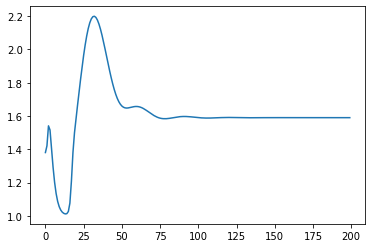

In [11]:
plt.plot(np.log10(E))

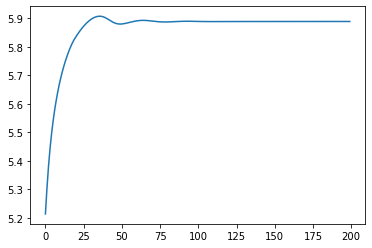

In [12]:
plt.plot(np.log10(T1))

In [14]:
FQI_buffer.get()

(array([[1.63573000e+05, 1.19450000e+04, 5.00000000e+00, 4.60000000e+01,
         6.39190000e+04, 2.40000000e+01],
        [1.99133864e+05, 1.21948890e+03, 3.80403636e+01, 3.31445905e+01,
         6.94253940e+03, 2.58476879e+01],
        [2.28512626e+05, 3.64658323e+03, 1.94443566e+01, 5.29257458e+01,
         1.92609101e+04, 2.88010438e+01],
        ...,
        [7.74589963e+05, 3.21815372e+03, 3.42440797e+01, 4.51712206e+01,
         1.21244139e+04, 3.89012715e+01],
        [7.74590793e+05, 3.21810210e+03, 3.42446478e+01, 4.51712502e+01,
         1.21242212e+04, 3.89016062e+01],
        [7.74591720e+05, 3.21806461e+03, 3.42450714e+01, 4.51712851e+01,
         1.21240810e+04, 3.89019507e+01]]),
 array([2, 0, 0, ..., 3, 3, 3]),
 array([ 7808.1       , 25153.43395065, 26874.95283491, ...,
        26088.83009048, 26089.18411797, 26089.54260198]),
 array([[1.99133864e+05, 1.21948890e+03, 3.80403636e+01, 3.31445905e+01,
         6.94253940e+03, 2.58476879e+01],
        [2.28512626e+05, 3.6

In [15]:
np.array(FQI_buffer.actions).shape

(6201,)

In [80]:
_, _, rewards, _, _  = FQI_buffer.get()